In [1]:
import os
import inspect
import pandas as pd
from PIL import Image

import prefect
import datetime
from prefect.tasks.shell import ShellTask
from prefect import Flow,task
from prefect.schedules import IntervalSchedule
from prefect.engine.signals import SKIP

In [2]:
@task
def filepath(Xfolder,SFolder,Folder,File):

    cwd = os.path.dirname(os.path.dirname(os.path.abspath(inspect.stack()[0][1])))
    print(cwd)
    read_file = os.path.join(cwd,Xfolder,SFolder,Folder,File)
    return read_file

In [3]:
@task
def git_clone(url: str) -> str:
    """
    The curl command we wish to execute.
    """
    return "! git clone  {url}".format(url=url)


# ShellTask is a task from the Task library which will execute a given command in a subprocess
# and fail if the command returns a non-zero exit code

download_raw_data = ShellTask(name="downloading_git_repo", max_retries=2, retry_delay=datetime.timedelta(seconds=10))

In [4]:
@task
def ch_dir(fname: str) -> str:
    """
    The curl command we wish to execute.
    """
    print("% cd {fname}".format(fname=fname))
    return "% cd {fname}".format(fname=fname)


# ShellTask is a task from the Task library which will execute a given command in a subprocess
# and fail if the command returns a non-zero exit code

download_1 = ShellTask(name="changin_directory", max_retries=2, retry_delay=datetime.timedelta(seconds=10))

In [5]:
@task
def filter_data():    #can restructor into functions
    """
    reading data
    """

    meta_path=filepath('',"data","covid-chestxray-dataset","metadata.csv")
    img_folder=filepath('',"data","covid-chestxray-dataset","images")
    raw_data=pd.read_csv(meta_path)
    imgs_path=[file for file in os.listdir(img_folder)]

    """
    Filtering data for PA,AP,AP Supine
    """      

    filter_list=['PA','AP','AP Supine']
    df=raw_data[raw_data['view'].isin(filter_list)]
    print("filter df length ",len( df))     #to be del

    df=df[df['filename'].isin(imgs_path)] 
    print("filter df length ",len( df))     #to be del

    """
    Filtering based on size of xrays
    """
    
    for item in df['filename']:
        df.loc[df['filename'] == item, 'height'],df.loc[df['filename'] == item, 'width']=Image.open(os.path.join(img_folder,item)).size



    df_included=df[(df['height']>1024) & (df['width']>1024)] 
    df_excluded=df[~df['filename'].isin(df_included['filename'])]

    return df_included,df_excluded

In [6]:
schedule=IntervalSchedule(interval=datetime.timedelta(minutes=5))

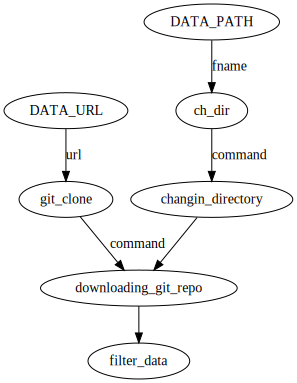

In [11]:
from prefect import Parameter, Flow


DATA_URL = Parameter("DATA_URL",
                     default="https://github.com/ieee8023/covid-chestxray-dataset")

DATA_PATH = Parameter("DATA_PATH", default="/content/drive/My Drive/data_pipeline/data")   #check if you can use function to set default value
DATA_PATH

with Flow("Image ETL") as flow:
    


    command2 = ch_dir(DATA_PATH)
    cli_dr = download_1(command=command2)
   
    command = git_clone(DATA_URL)
    input_data = download_raw_data(command=command,upstream_tasks=[cli_dr])


    #Transform

    filter_status=filter_data(upstream_tasks=[input_data])


    # Load




flow.visualize()

In [8]:
flow.run()

ModuleNotFoundError: No module named 'pidycom'